# Lec 07: Neural Networks, Gradient Regression, and Quantum Chemistry

In [2]:
import matplotlib.pyplot as plt
from functools import partial

## Goal

1. Introduce **(artificial) neural networks** (NN) and the concept of **deep learning**.
2. Use NNs to perform gradient regression.
3. Connect the concepts we have seen earlier in this class in a walkthrough of a **research paper**. This paper introduces a NN for quantum chemistry called Schnet.

## Neural Networks

1. We'll introduce popular neural network library called `PyTorch`.
2. We'll show how to build a simple neural network with PyTorch.
3. We'll connect it to the concepts we've seen before.

In [3]:
# Libraries that we have seen before
import numpy as np
import jax
import jax.numpy as jnp 

# PyTorch: popular neural network library
import torch

### Tensors

In [4]:
# Declare a vector of length 3
print(np.array([1., 2., 3.]))
print(jnp.array([1., 2., 3.]))
print(torch.tensor([1., 2., 3.]))

[1. 2. 3.]
[1. 2. 3.]
tensor([1., 2., 3.])


Corresponding vector
$$
\begin{pmatrix}
1 \\
2 \\
3
\end{pmatrix}
$$

In [5]:
# Declare a matrix of length 2x3
print(np.array([[1., 2., 3.], [4., 5., 6.]]))
print(jnp.array([[1., 2., 3.], [4., 5., 6.]]))
print(torch.tensor([[1., 2., 3.], [4., 5., 6.]]))

[[1. 2. 3.]
 [4. 5. 6.]]
[[1. 2. 3.]
 [4. 5. 6.]]
tensor([[1., 2., 3.],
        [4., 5., 6.]])


Corresponding matrix
$$
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6
\end{pmatrix}
$$

In [6]:
# Converting a numpy array to a torch tensor
torch.tensor(np.array([[1., 2., 3.], [4., 5., 6.]]))

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)

### Basic Operations

In [7]:
# Stacking
A_1 = torch.tensor([1., 2., 3.])
A_2 = torch.tensor([4., 5., 6.])
torch.stack([A_1, A_2]), torch.stack([A_1, A_2], dim=1)

(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 tensor([[1., 4.],
         [2., 5.],
         [3., 6.]]))

Corresponding operation
$$
\begin{pmatrix}
1 \\
1 \\
1 \\
\end{pmatrix} + 
\begin{pmatrix}
2 \\
2 \\
2 \\
\end{pmatrix} = 
\begin{pmatrix}
3 \\
3 \\
3 \\
\end{pmatrix}
$$

In [8]:
A = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
B = torch.ones(2, 3)
A * B

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [9]:
# Element-wise operations
x = torch.tensor([1., 1., 1.]) 
y = torch.tensor([2., 2., 2.]) 
x + y

tensor([3., 3., 3.])

$$
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6
\end{pmatrix} \odot
\begin{pmatrix}
1 & 1 & 1 \\
1 & 1 & 1
\end{pmatrix} = 
\begin{pmatrix}
1 & 2 & 3\\
4 & 5 & 6
\end{pmatrix}
$$

In [10]:
# Matrix multiplication
A = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
x = torch.tensor([1., 1., 1.]) 
A @ x

tensor([ 6., 15.])

$$
\begin{pmatrix}
1 & 2 & 3\\
4 & 5 & 6
\end{pmatrix}
\begin{pmatrix}
1 \\
1 \\
1 \\
\end{pmatrix}
=
\begin{pmatrix}
6 \\
15 \\
\end{pmatrix}
$$

### Summary

1. Like Numpy and Jax, PyTorch gives us operations for manipulating vectors and matrices.
2. Like Jax, PyTorch will also give us the ability to perform automatic differentiation.
3. We'll illustrate with linear regression first.

### Linear Regression in PyTorch from scratch

First let's recall our 3 point dataset.

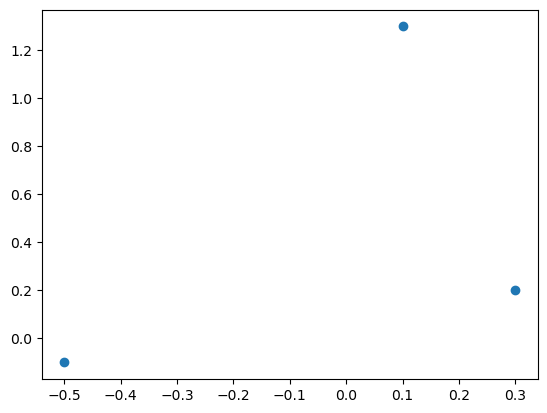

In [11]:
x1 = [0.3]                          # each point has dimension 1
x2 = [-0.5]               
x3 = [.1]                
y = torch.tensor([0.2, -.1, 1.3])   # target values
X = torch.tensor([x1, x2, x3])      # each row is one input

plt.plot(X[:,0], y, marker='o', linestyle='none')

In [12]:
# Compare with numpy version 
#
# def fit_regression(X, y):
#     A = np.concatenate([X, np.ones((X.shape[0],1))], axis=1)
#     return np.linalg.solve(A.transpose() @ A, A.transpose() @ y)

def fit_regression(X: torch.tensor, y: torch.tensor) -> torch.tensor:
    A = torch.cat([X, torch.ones((X.shape[0],1))], dim=1)
    return torch.linalg.solve(A.t() @ A, A.t() @ y)

In [13]:
# Solve for weights
weights = fit_regression(X, y)
weights

tensor([0.8269, 0.4942])

In [14]:
# Perform predictions
def prediction(weights, x):
    return x.t() @ weights[:-1] + weights[-1]

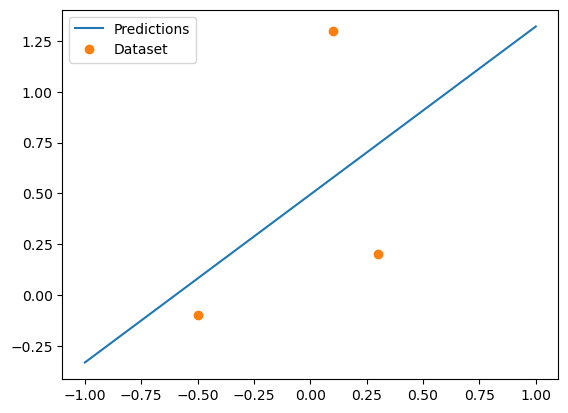

In [15]:
# Plot predictions
f_hat = partial(prediction, weights)
plt.plot(torch.linspace(-1.0, 1.0, 10), [f_hat(torch.tensor([x])) for x in torch.linspace(-1.0, 1.0, 10)], label='Predictions')
plt.plot(X, y, marker='o', linestyle='None', label='Dataset')
plt.legend()

### What about using gradient descent?

In [16]:
# Create the model. It's simply the prediction function.
def model(weights: torch.tensor, bias: torch.tensor, x: torch.tensor) -> torch.tensor:
    return x @ weights.t() + bias

In [17]:
# The traditional mean-squared error loss
def mse_loss(model, weights: torch.tensor, bias: torch.tensor, X: torch.tensor, y: torch.tensor):
    pred_y = model(weights, bias, X)
    loss = ((pred_y - y.reshape(-1, 1))**2).sum()
    return loss

In [18]:
def sgd(model, X: torch.tensor, y: torch.tensor, lr=1e-4, niter=50):
    weights = torch.randn(1, 1, requires_grad=True)
    bias = torch.randn(1, requires_grad=True)
    for i in range(niter):
        # 1. Compute the loss
        loss = mse_loss(model, weights, bias, X, y)
        # 2. Tell PyTorch to keep the gradients of all intermediate values
        weights.retain_grad()
        bias.retain_grad()
        # 3. Tell PyTorch to compute the gradient with reverse-mode AD
        loss.backward()
        # 4. Perform the optimization step.
        weights = weights - lr * weights.grad
        bias = bias - lr * bias.grad
    return weights, bias

In [19]:
weights, bias = sgd(model, X, y, lr=1e-1)
weights, bias

(tensor([[0.8001]], grad_fn=<SubBackward0>),
 tensor([0.4932], grad_fn=<SubBackward0>))

/opt/homebrew/Caskroom/miniconda/base/envs/csc890/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/homebrew/Caskroom/miniconda/base/envs/csc890/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


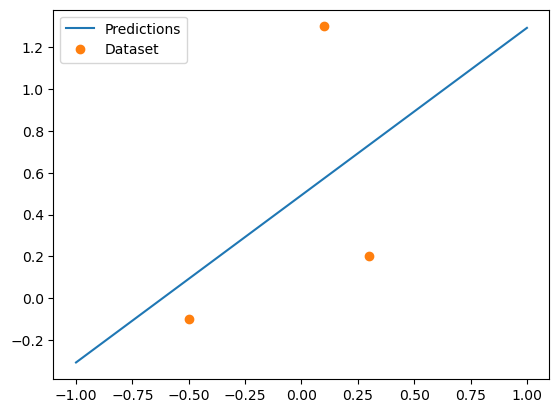

In [20]:
# Plot predictions
def prediction(weights: torch.tensor, bias: torch.tensor, x: torch.tensor) -> torch.tensor:
    # detach is a PyTorch specific function related to its automatic-differentiation capabilities
    return model(weights, bias, x).detach()

f_hat = partial(prediction, weights, bias)
plt.plot(torch.linspace(-1.0, 1.0, 10), [f_hat(torch.tensor([x])) for x in torch.linspace(-1.0, 1.0, 10)], label='Predictions')
plt.plot(X.detach(), y.detach(), marker='o', linestyle='None', label='Dataset')
plt.legend()

### Linear Regression in PyTorch Using Neural Network Builtins

In [21]:
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        # 1. We construct a 1 weight for the slope
        # 2. We construct 1 weight for the bias
        self.weights = nn.Linear(1, 1)

    def forward(self, x):
        # Notice that we are doing a simple linear transformation here
        return self.weights(x)

In [22]:
# 1. Initialize the model
model = LinearRegression()
# 2. Print the model weights
print("slope", model.weights.weight)
print("offset", model.weights.bias)

slope Parameter containing:
tensor([[-0.7189]], requires_grad=True)
offset Parameter containing:
tensor([-0.7936], requires_grad=True)


In [23]:
# 3. Evaluate the model
model(torch.tensor([1.0]))

tensor([-1.5125], grad_fn=<AddBackward0>)

In [24]:
# 4. We can check the model parameters
print("Initial model parameters ...")
for parameter in model.parameters():
    print(parameter)

Initial model parameters ...
Parameter containing:
tensor([[-0.7189]], requires_grad=True)
Parameter containing:
tensor([-0.7936], requires_grad=True)


In [25]:
from torch import optim

# 1. Create the model
model = LinearRegression()
# 2. Define the loss
mse_loss = torch.nn.MSELoss()
# 3. Select an optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-1)
# 4. Design training procedure
for i in range(200):
    # a. Use the model to form a prediction on the dataset X
    #    Note that we haven't used batching where we split the dataset X into chunks
    pred_y = model(X)
    # b. Compute the loss
    loss = mse_loss(pred_y, y.reshape(-1, 1))
    # c. Stateful programming in PyTorch, again ...
    #    The optimizer mutates all the tensors present in the model to propagate gradient information.
    #    Thus we need to "zero" all the gradients.
    optimizer.zero_grad()
    # d. Compute the gradient of the model w.r.t. the loss function.
    loss.backward()
    # e. Take an optimization step using the optimizer.
    optimizer.step()

#### Checking the learned model parameters

In [26]:
print("Learned model parameters ...")
for parameter in model.parameters():
    print(parameter)

Learned model parameters ...
Parameter containing:
tensor([[0.8212]], requires_grad=True)
Parameter containing:
tensor([0.4940], requires_grad=True)


#### Plotting the learned model

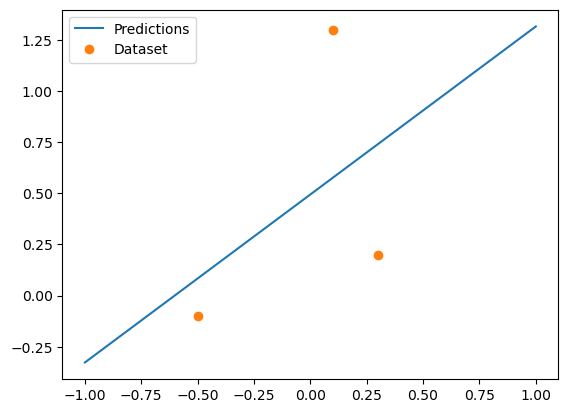

In [27]:
plt.plot(torch.linspace(-1.0, 1.0, 10), [model(torch.tensor([x])).detach() for x in torch.linspace(-1.0, 1.0, 10)], label='Predictions')
plt.plot(X.detach(), y.detach(), marker='o', linestyle='None', label='Dataset')
plt.legend()

### Summary

1. The PyTorch nn module provides a clean interface for wrapping up a model and it's learneable weights.
2. The PyTorch usage of `.backward()` tells the underlying automatic differentiation engine to compute gradies and store in the `.grad` variable. When using the nn module, all of this is hidden from the user.
3. The PyTorch `optim` module gives access to many different optimizers including stochastic gradient descent.

## Neural Networks

The real power of a a neural network is to
1. Introduce non-linearities so that non-linear models can be formed.
2. Stack layers so that these models can be trained more easily.

In [28]:
class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN, self).__init__()
        self.layer1 = nn.Linear(64, 8)  # First layer of parameters
        self.layer2 = nn.Linear(8, 1)   # Second layer of parameters

    def forward(self, x):
        # Linear transformation 1
        t1 = self.layer1(x)
        # Non-linearity 1
        t2 = nn.Sigmoid()(t1)
        # Linear transformation 2
        t3 = self.layer2(t2)
        # Non-linearity 2
        t4 = nn.Sigmoid()(t3)
        return t4

In [29]:
model = TwoLayerNN()

In [30]:
model(torch.randn(64))

tensor([0.5360], grad_fn=<SigmoidBackward0>)

In [31]:
print("Initial model parameters ...")
for parameter in model.parameters():
    print(parameter)

Initial model parameters ...
Parameter containing:
tensor([[ 0.0204,  0.0953,  0.1045, -0.1053,  0.0028, -0.1047,  0.0616,  0.0812,
          0.0622, -0.0396, -0.0449, -0.0698, -0.1138, -0.0804,  0.0666,  0.0168,
          0.0284, -0.0266, -0.0083, -0.0577, -0.0789,  0.1046, -0.0491, -0.0229,
         -0.0528, -0.1151, -0.0566,  0.0711,  0.1249, -0.0049, -0.0164,  0.0313,
         -0.0804,  0.1151, -0.0434, -0.0781, -0.1035,  0.1211,  0.1061, -0.0012,
          0.1035, -0.0562, -0.0617,  0.0407,  0.0886, -0.0164, -0.1068, -0.0815,
         -0.0700,  0.0496, -0.1105,  0.0961, -0.0709,  0.0368, -0.0063, -0.0505,
         -0.0445,  0.0901, -0.0316,  0.1162, -0.0877,  0.0751,  0.0716,  0.1123],
        [-0.0175, -0.0374, -0.0639, -0.1107, -0.0742, -0.0925, -0.1144, -0.0018,
          0.0597,  0.0849, -0.1021, -0.0019, -0.0134, -0.0930,  0.0813,  0.0301,
          0.0626, -0.0695,  0.0181, -0.0562, -0.0538,  0.0487,  0.0051,  0.0472,
          0.0803, -0.0763, -0.0213, -0.1179, -0.0349,  0.

### Mathematical Notation

The neural network we have defined is $f$
$$
f(x; A_1, b_1, A_2, b_2) = \sigma(A_2 \sigma(A_1 x + b_1) + b_2)
$$
where
1. $A_1$ and $b_1$ are associated with `model.layer1.weight` and `model.layer1.bias` respectively
2. $A_2$ and $b_2$ are associated with `model.layer2.weight` and `model.layer2.bias` respectively
3. $\sigma$ is the sigmoid activation function


In [32]:
# New data
X = torch.randn(100, 64)
b = torch.ones(100)

# Changed model
model = TwoLayerNN()

# Everything else is the same
mse_loss = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)
epochs = 200
for i in range(epochs):
    pred_y = model(X)
    loss = mse_loss(pred_y, b.reshape(-1, 1))
    optimizer.zero_grad()
    loss.backward() # This handles all the gradients
    optimizer.step()
    
print("Learned model parameters ...")
for parameter in model.parameters():
    print(parameter)

Learned model parameters ...
Parameter containing:
tensor([[ 0.0436, -0.1162, -0.0067,  0.0859,  0.0430, -0.0962,  0.0350, -0.0854,
          0.0920,  0.1026,  0.0844,  0.0456, -0.1027, -0.0337, -0.1222, -0.1073,
          0.0079, -0.0745,  0.0404,  0.0334, -0.0294, -0.0933,  0.1012,  0.0775,
          0.0379, -0.0911,  0.0033,  0.0356, -0.0576, -0.0368, -0.1088, -0.0708,
          0.0028, -0.0291, -0.0342, -0.1172, -0.1013,  0.0643,  0.0964, -0.0946,
         -0.0136,  0.0377, -0.0969,  0.1189, -0.0638,  0.0914,  0.0104, -0.0063,
         -0.0385,  0.0934, -0.1115,  0.0453,  0.0560, -0.0982,  0.1246,  0.0164,
         -0.0622,  0.0878,  0.0791,  0.0959,  0.0234,  0.0155, -0.0210,  0.0071],
        [-0.0318, -0.0863,  0.1200,  0.1281, -0.0238,  0.1073, -0.0704, -0.0962,
         -0.0487, -0.0076,  0.0747, -0.0294, -0.0732, -0.0648, -0.0468, -0.1199,
          0.1056,  0.0227,  0.0141, -0.0343, -0.0502, -0.0406, -0.0934,  0.0961,
          0.0959,  0.0233,  0.0268,  0.0961, -0.0152,  0.

In [33]:
mse_loss(model(X), b.reshape(-1, 1))

tensor(0.0052, grad_fn=<MseLossBackward0>)

In [34]:
model(X)

tensor([[0.9272],
        [0.9206],
        [0.9134],
        [0.9185],
        [0.9267],
        [0.9258],
        [0.9373],
        [0.9296],
        [0.9361],
        [0.9203],
        [0.9385],
        [0.9364],
        [0.9368],
        [0.9282],
        [0.9266],
        [0.9237],
        [0.9463],
        [0.9312],
        [0.9382],
        [0.9325],
        [0.9325],
        [0.9074],
        [0.9219],
        [0.9422],
        [0.9302],
        [0.9345],
        [0.9216],
        [0.9300],
        [0.9429],
        [0.9038],
        [0.9085],
        [0.9456],
        [0.9277],
        [0.9284],
        [0.9351],
        [0.9190],
        [0.9371],
        [0.9195],
        [0.9346],
        [0.9209],
        [0.9061],
        [0.9359],
        [0.9427],
        [0.9299],
        [0.9368],
        [0.9421],
        [0.9372],
        [0.9221],
        [0.9409],
        [0.9202],
        [0.9197],
        [0.9294],
        [0.9419],
        [0.9293],
        [0.9259],
        [0

In [35]:
test_X = torch.randn(1000, 64)
test_y = model(test_X).reshape(-1)
test_y.min(), test_y.max(), test_y.mean()

(tensor(0.8696, grad_fn=<MinBackward1>),
 tensor(0.9526, grad_fn=<MaxBackward1>),
 tensor(0.9249, grad_fn=<MeanBackward0>))

### Mean-Squared Error Loss

As a reminder, minimizing the mean-squared error loss is equivalent to maximizing the conditional density
\begin{align*}
p(y) & = \prod_{i=1}^N p(y_i) \\
\end{align*}
where
1. $p(y_i) = \mathcal{N}(f(x_i), 1)$
2. $f(x; A_1, b_1, A_2, b_2) = \sigma(A_2 \sigma(A_1 x + b_1) + b_2)$

### Neural Network Zoo

1. There are many neural network architectures. (There are also many activation functions.)
    - Convolutional neural networks (good for images)
    - Transformers (good for text, basically anything at this point)
    - Recurrent neural networks (good for sequences)
2. In essence, all of these correspond to choosing a matrix A and bias b of a certain shape.
3. Each architecture provides an inductive bias that helps the model learn an appropriate representation. In this sense, a fully-connected layer, i.e., dense matrix A provides the least inductive bias.

### Optional: Understanding how gradients propagate

Let's rewrite the original function as
\begin{align*}
f(x; A_1, b_1, A_2, b_2) & = \sigma(y_2) \\
y_2 & = A_2 \sigma(y_1) + b_2 \\
y_1 & = A_1 x + b1
\end{align*}

Suppose we are interested in the update to parameter $A_1$ so we compute its gradient
\begin{align*}
\frac{\partial f}{\partial A_1} & = \frac{d\sigma}{dy_2} \frac{d y_2}{dy_1} \frac{d y_1}{dA_1} \\
\frac{d y_2}{dy_1} & = A_2 \frac{d\sigma}{dy_1} \\
\frac{d y_1}{dA_1} & = x
\end{align*}

Thus
$$
\frac{\partial f}{\partial A_1} = \left( \frac{d\sigma}{dy_2}|_{y_2 = A_2 \sigma(y_1) + b_2} \right) \left( A_2 \frac{d\sigma}{dy_1}|_{y_1 = A_1 x + b1} \right) x
$$


## On to Gradient Regression!

1. Let $(x_i, (y_i, dy_i/dx_i))_i$ be a dataset.
2. Develop a model and a training procedure such that 
$f_\theta(x)$ fits $y$ and $\frac{\partial}{\partial x}f_\theta(x)$ fits $dy_i/dx_i$.

Text(0.5, 1.0, 'Gradient Regression')

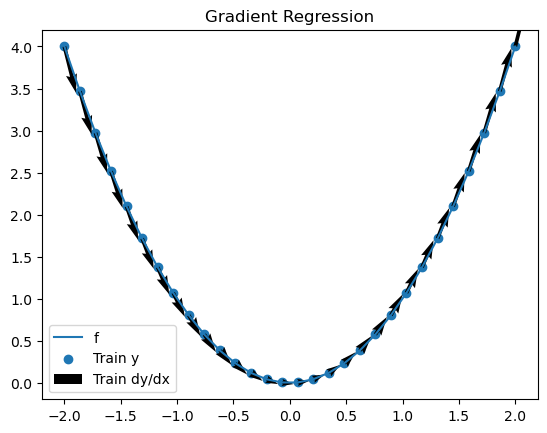

In [36]:
# Synthetic functions
f = lambda x: x**2
grad_f = lambda x: 2*x

# Synthetic functions evaluated at xs
xs = torch.linspace(-2, 2, 30)
ys = torch.tensor([f(x) for x in xs])
dy_dxs = torch.tensor([grad_f(x) for x in xs])

# Plotting dataset
plt.plot(xs, ys, label='f')
plt.scatter(xs, ys, label='Train y')

# Plot gradients
origin = torch.stack([xs, ys])
plt.quiver(*origin, np.ones(len(xs)), dy_dxs, label='Train dy/dx')
plt.legend(); plt.title('Gradient Regression')

### Gradient Regression with Neural Network Linear Regression

1. We'll now look at neural networks for the gradient regression problem.
2. As always, we should start with the simplest model.

In [39]:
class GradLinearRegression(nn.Module):
    def __init__(self, D: int):
        super(GradLinearRegression, self).__init__()
        self.weights = nn.Linear(D, 1)

    def forward(self, x):
        # Notice that we are doing a simple linear transformation here
        y = self.weights(x)

        # Next we need to take the derivative of the model's prediction w.r.t. x
        dy_dx = torch.autograd.grad(
            y, # the y value
            x, # the value to take the derivative w.r.t.
            grad_outputs=torch.ones_like(x), # the shape of the output
            create_graph=True,)[0] # PyTorch AD details, we need this since we will
                                   # differentiate the function again w.r.t. the parameters
        return torch.cat([y, dy_dx], dim=-1)

In [50]:
# Construct a model and make sure it runs
gradModel = GradLinearRegression(1)
gradModel(torch.tensor([1.], requires_grad=True))

tensor([0.6979, 0.5416], grad_fn=<CatBackward0>)

#### Model in mathematical notation

The code that we have written corresponds to the model below
\begin{align*}
y & = f(x; w; b) = w^T x + b \\
\frac{dy}{dx} & = \nabla_x f(x; w, b) = w
\end{align*}

As a reminder, we are using AD to obtain the gradient of the model w.r.t. the input x.

In [51]:
mse_loss = torch.nn.MSELoss()
def gradreg_loss(x, y):
    return mse_loss(x[:,0], y[:,0]) + mse_loss(x[:,1:], y[:,1:])

In [52]:
# Create model
gradModel = GradLinearRegression(1)

# Reshape training data
train_X = xs.reshape(-1, 1).requires_grad_()
train_y = torch.tensor([(ys[i], dy_dxs[i]) for i in range(len(ys))])

# Setup optimizer
optimizer = optim.SGD(gradModel.parameters(), lr=1e-1)
epochs = 200
for i in range(epochs):
    # Compute loss
    pred_y = gradModel(train_X)
    loss = gradreg_loss(pred_y, train_y)

    # Optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [53]:
print("Learned model parameters ...")
for parameter in gradModel.parameters():
    print(parameter)

Learned model parameters ...
Parameter containing:
tensor([[-6.8584e-08]], requires_grad=True)
Parameter containing:
tensor([1.4253], requires_grad=True)


Text(0.5, 1.0, 'Gradient Regression')

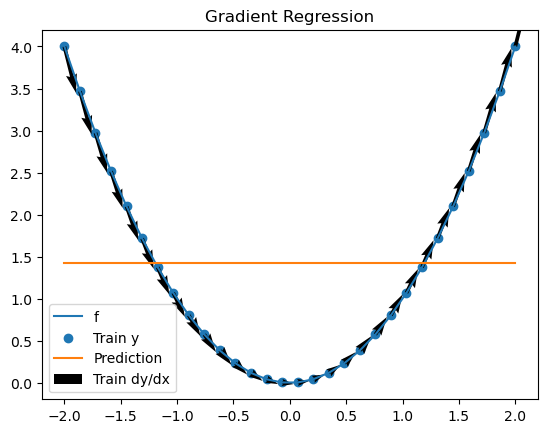

In [54]:
# Plotting dataset
plt.plot(xs, ys, label='f')
plt.scatter(xs, ys, label='Train y')
plt.plot(xs, [gradModel(torch.tensor([x], requires_grad=True)).detach()[0] for x in xs], label='Prediction')

# Plot gradients
origin = torch.stack([xs, ys])
plt.quiver(*origin, np.ones(len(xs)), dy_dxs, label='Train dy/dx')
plt.legend(); plt.title('Gradient Regression')

### Summary

1. We had a gentle introduction to neural networks.
2. We saw how to use the PyTorch library to replicate all the simple models we have seen in class.
3. We encoded the gradient regression problem as a neural network in PyTorch.

## SchNet: A continuous-filter convolutional neural network for modeling quantum interactions

1. Paper: [https://arxiv.org/pdf/1706.08566.pdf](https://arxiv.org/pdf/1706.08566.pdf).
2. We now have tools we need to dive into research on how to construct neural networks for quantum chemistry.
3. These neural networks try to replicate the PES of a molecular system.

### How to read research paper?

1. Read the **abstract** to figure out what problem the paper is addressing and what the conclusions are.
2. Read the **introduction** to figure out what problem the paper is addressing.
3. Read the **conclusion** to figure out what the solution to the problem is.
4. Read the **experiments** to figure out how they justify their conclusions with quantifiable metrics.
5. If the paper is still interesting, read the **methods** to figure out what they actually did. In this case, it useful to look for code: [https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/schnet.html](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/schnet.html)

### Abstract

1. Develop a new neural network architecture that modifies a convolutional neural network to work with atoms.
2. Develop a model called Schnet that models a PES.
3. Benchmark models on tasks that identify limitations.

### Introduction

From the paper:
1. We propose continuous-filter convolutional (cfconv) layers as a means to move beyond
grid-bound data such as images or audio towards modeling objects with arbitrary positions
such as astronomical observations or atoms in molecules and materials.
2. We propose SchNet: a neural network specifically designed to respect essential quantumchemical constraints. In particular, we use the proposed cfconv layers in R3 to model
interactions of atoms at arbitrary positions in the molecule. SchNet delivers both rotationally
invariant energy prediction and rotationally equivariant force predictions. We obtain a
smooth potential energy surface and the resulting force-field is guaranteed to be energyconserving.
3. We present a new, challenging benchmark – ISO17 – including both chemical and conformational changes. We show that training with forces improves generalization in this setting
as well.

### Conclusion

1. The architecture works: "We have developed SchNet to demonstrate the capabilities of continuous-filter convolutional layers in the context of modeling quantum interactions in molecules. Our architecture respects quantum-chemical constraints such as rotationally invariant energy predictions as well as rotationally equivariant, energy-conserving
force predictions."
2. A sequence of tasks: chemical degrees of freedom, conformational degrees of freedom, chemical and conformational degrees of freedom. "We have evaluated our model in three increasingly challenging experimental settings. Each brings us one step closer to practical chemical exploration driven by machine learning. SchNet improves the state-of-the-art in predicting energies for molecules in equilibrium of the QM9 benchmark. Beyond that, it achieves accurate predictions for energies and forces for all molecular dynamics trajectories in MD17. Finally, we have introduced ISO17 consisting of 645,000 conformations of various C7O2H10 isomers. While we achieve promising results on this new benchmark, modeling chemical and
conformational variations remains difficult and needs further improvement. For this reason, we expect
that ISO17 will become a new standard benchmark for modeling quantum interactions with machine
learning."

### Experiments

Tasks in increasing order of difficulty
1. Chemical degress of freedom: QM9 dataset
2. Conformational degrees of freedom: MD17 dataset
3. Chemical and conformational degrees of freedom: ISO 17 dataset

#### Chemical Degrees of Freedom

1. All molecules are at equilibrium
2. We are trying to predict energy (since force is 0)

![table1.png](./table1.png)


#### Conformational Degrees of Freedom

1. We take different geometries of the same molecule.
2. We are trying to predict energy and force. This is the gradient regression setting.

![table2.png](./table2.png)


#### Chemical and Conformational Degrees of Freedom

1. We vary the molecules and the geometries of the molecules.
2. We try to predict the energy and the force.
3. Clearly this is the hardest task since we need to transfer knowledge from one molecule to a different one.

![table3.png](./table3.png)


### Methods

1. Now that we know that we know what problems the paper is addressing, what the conclusions are, and what the experiments that justify those conclusions looks like, we can dive into the methods.
2. This is where it's important to get hands on and get code! [https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/schnet.html](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/schnet.html)

#### Demonstration

```py
python train_schnet.py
```

#### Continuous-Filter Convolution

![cfc.png](cfc.png)

In [68]:
from torch import Tensor
from torch.nn import Sequential  # Used for sequencing layers
from torch_geometric.nn import MessagePassing  # PyTorch graph neural network package

# Continuous-filter convolutions, section 3 of paper
class CFConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, num_filters: int,
                 nn: Sequential, cutoff: float):
        super().__init__(aggr='add')

        # Parameters
        self.lin1 = Linear(in_channels, num_filters, bias=False)  # D x l
        self.lin2 = Linear(num_filters, out_channels)             # l x F
        self.nn = nn                                              # Sequence
        
        self.cutoff = cutoff
        
        self.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_weight: Tensor,
                edge_attr: Tensor) -> Tensor:
        # THe implementation of the layer
        C = 0.5 * (torch.cos(edge_weight * PI / self.cutoff) + 1.0)
        W = self.nn(edge_attr) * C.view(-1, 1)

        x = self.lin1(x)
        x = self.propagate(edge_index, x=x, W=W)
        x = self.lin2(x)
        return x

    def message(self, x_j: Tensor, W: Tensor) -> Tensor:
        return x_j * W

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

#### Training with Energies and Forces

![ef.png](ef.png)

Excerpt from Schnet model
```py
    def forward(self, data):
        z = data["z"]
        pos = data["R"]
        batch = data["batch"]

        if self.regress_forces:
            pos.requires_grad_(True)

        energy = super(SchNetWrap, self).forward(z, pos, batch=batch)

        if self.regress_forces:
            # This is where we are predicting the force by taking the gradient
            # w.r.t. the model
            forces = -1*(torch.autograd.grad(energy, pos, grad_outputs=torch.ones_like(energy), create_graph=True,)[0])
            return {"E":energy, "F":forces}
        else:
            return {"E":energy}
```

#### Loss Function

![loss.png](loss.png)

Excerpt from code
```py
def EnergyLoss(pred, label):
    p, l = pred["E"].squeeze(), label["E"].squeeze()
    mae = torch.nn.L1Loss()  # note that this is MAE and not MSE!
    return mae(p, l)

def AtomForceLoss(pred, label):
    p, l = pred["F"].squeeze(), label["F"].squeeze()
    p = p.reshape((-1, 3))
    l = l.reshape((-1, 3))
    mae = torch.nn.L1Loss()  # note that this is MAE and not MSE!
    return torch.Tensor([mae(p[i], l[i]) for i in range(len(p))])

def EnergyForceLoss(pred, label):
    E = EnergyLoss(pred, label)
    F = AtomForceLoss(pred, label)
    return E + 30*torch.mean(F)
```

### Summary

1. We saw how to map parts of the paper to an actual implementation.
2. In particular, the implementation and the paper didn't exactly match up. This is because the code is the "ground truth" and has evolved since the paper was published. This is why we always emphasize the code.
3. We hopefully began to see how the fundamentals we've been learning are at play in the context of real research in this field.